<a href="https://colab.research.google.com/github/hairo1421/Maestria-Computo-Estadistico/blob/master/Copia_de_Tarea3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center>Tarea 3<center>
# <center>Para entregar el 25 de octubre<center>

## 1. Para efectos de comparar el desempeño de las redes neuronales recurrentes con *compuertas*, considera los dos buenos artículos de Chung et al. (2014) y Greff et al. (2017). Leélos y haz un breve resúmen con los aspectos más importantes que consideres, con el fin de tener un mejor panorama de éstos métodos.

# Nueva sección

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### <font color=green>Tu respuesta aquí</font>

In [2]:
%cd /content/drive/My Drive/Colab Notebooks/Tarea 3-20191016/midi_train/midi_train


/content/drive/My Drive/Colab Notebooks/Tarea 3-20191016/midi_train/midi_train


In [3]:
!pwd

/content/drive/My Drive/Colab Notebooks/Tarea 3-20191016/midi_train/midi_train


## 2. Considera un corpus de obras (cortas) de piano en formato `MIDI` como las que se encuentran en la carpeta `midi_train`.

## a) Crea música usando redes tipo LSTM. Puedes apoyarte en el código que pongo a continuación (detalles en clase).

In [4]:
%pip install tensorflow==1.13.1

     |████████████████████████████████| 92.5MB 1.3MB/s 
     |████████████████████████████████| 3.2MB 33.1MB/s 
     |████████████████████████████████| 368kB 49.3MB/s 
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorflow 1.15.0rc3
    Uninstalling tensorflow-1.15.0rc3:
      Successfully uninstalled tensorflow-1.15.0rc3


In [0]:
import tensorflow 

from tensorflow.keras.models import Sequential

In [22]:
tensorflow.version.VERSION

'1.13.1'

In [6]:
import pickle
import numpy
import os
from music21 import converter, instrument, note, chord, stream
from IPython.display import Image

from tensorflow.keras.models import Sequential,  Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Activation
from keras.utils import np_utils, plot_model
from tensorflow.keras.callbacks import ModelCheckpoint

#os.chdir('/home/victor/cursos/optativa2019/')
# el directorio con el corpus de entrenamiento
midi_songs = '/content/drive/My Drive/Colab Notebooks/Tarea 3-20191016/midi_train/midi_train'

Using TensorFlow backend.


La parte que sigue puede usarse para el proceso de entrenamiento

In [0]:
def get_notes():
    %cd /content/drive/My Drive/Colab Notebooks/Tarea 3-20191016/midi_train/
    """ Obtiene las notas y acordes de los archivos midi que se encuentran en el directorio /midi_songs """
    notes = []
    notes2 = []

    for file in os.scandir(midi_songs):
        midi = converter.parse(file.path)

        print("Analizando %s" % file.name)

        notes_to_parse = None
        notes_to_parse2 = None

        # en esta parte, se extraen todas las notas del archivo midi
        # como 'midi' es un objeto Score (que a su vez hereda de un Stream),
        # pueden accederse a todas las partes de la partitura (Score)
        
        # en el try, primero se extraen las partes para cada instrumento
        # solo se usa el primero (aunque puedan haber mas de 1)
        try: 
            s2 = instrument.partitionByInstrument(midi)
            notes_to_parse = s2.parts[0].recurse() 
        except: # aqui se extraen todas las notas haciendo un 'flatten' (o sea, las vectorizamos)
            notes_to_parse = midi.flat.notes
          
        try: 
            s22 = instrument.partitionByInstrument(midi)
            notes_to_parse2 = s22.parts[1].recurse() 
        except: # aqui se extraen todas las notas haciendo un 'flatten' (o sea, las vectorizamos)
            notes_to_parse2 = midi.flat.notes

        for element in notes_to_parse:
            if isinstance(element, note.Note):
                notes.append(str(element.pitch))
            elif isinstance(element, chord.Chord):
                notes.append('.'.join(str(n) for n in element.normalOrder))

        for element2 in notes_to_parse2:
            if isinstance(element2, note.Note):
                notes2.append(str(element2.pitch))
            elif isinstance(element2, chord.Chord):
                notes2.append('.'.join(str(n) for n in element2.normalOrder))  

    # guarda las notas. Este paso es muy importante, ya que se usaran en la fase de test,
    # es decir, cuando se generan notas a partir del modelo entrenado
    with open('programs/notebooks/data_mid/notes', 'wb') as filepath:
        pickle.dump(notes, filepath)
    with open('programs/notebooks/data_mid/notes2', 'wb') as filepath:
        pickle.dump(notes2, filepath)

    return notes, notes2


def prepare_sequences(notes, n_vocab, sequence_length):
    """ Prepara las secuencias a usar en el modelo """

    # nuestro 'vocabulario' consiste en todas las notas unicas de los archivos midi
    pitchnames = sorted(set(item for item in notes))

     # se crea un diccionario para mapear notas a enteros
    note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

    network_input = []
    network_output = []

    # crea las secuencias de entrada y las salidas
    # podria usarse para una arquitectura 'many to one', pero también puedes
    # hacer un stack de RNNs (many to many)
    for i in range(0, len(notes) - sequence_length, 1):
        sequence_in = notes[i:i + sequence_length]
        sequence_out = notes[i + sequence_length]
        network_input.append([note_to_int[char] for char in sequence_in])
        network_output.append(note_to_int[sequence_out])

    n_patterns = len(network_input)

    # redimensiona las secuencias de entrada para la RNN a usar
    network_input = numpy.reshape(network_input, (n_patterns, sequence_length, 1))
    # normaliza
    network_input = network_input / float(n_vocab)

    network_output = np_utils.to_categorical(network_output)

    return (network_input, network_output)


In [8]:
notes, notes2 = get_notes()

/content/drive/My Drive/Colab Notebooks/Tarea 3-20191016/midi_train
Analizando alb_esp1.mid
Analizando alb_esp6.mid
Analizando alb_esp3.mid
Analizando alb_esp2.mid
Analizando alb_esp5.mid
Analizando alb_esp4.mid
Analizando alb_se1.mid
Analizando alb_se3.mid
Analizando alb_se6.mid
Analizando alb_se5.mid
Analizando alb_se4.mid
Analizando alb_se2.mid
Analizando alb_se7.mid
Analizando bach_847.mid
Analizando alb_se8.mid
Analizando bach_850.mid
Analizando bach_846.mid
Analizando chpn-p1.mid
Analizando chpn-p10.mid
Analizando chpn-p11.mid
Analizando chpn-p12.mid
Analizando chpn-p13.mid
Analizando chpn-p14.mid
Analizando chpn-p16.mid
Analizando chpn-p15.mid
Analizando chpn-p18.mid
Analizando chpn-p17.mid
Analizando chpn-p2.mid
Analizando chpn-p19.mid
Analizando chpn-p20.mid
Analizando chpn-p3.mid
Analizando chpn-p22.mid
Analizando chpn-p24.mid
Analizando chpn-p23.mid
Analizando chpn-p21.mid
Analizando chpn-p5.mid
Analizando chpn-p4.mid
Analizando chpn-p6.mid
Analizando chpn-p7.mid
Analizando 

In [9]:
# puedes probar con varios longitudes de secuencias...
sequence = 100
# cantidad de notas
n_vocab = len(set(notes))
print('vocabulario:', n_vocab)


n_vocab2 = len(set(notes2))
print('vocabulario:', n_vocab2)

vocabulario: 416
vocabulario: 416


In [0]:
network_input, network_output = prepare_sequences(notes, n_vocab, sequence)

network_input2, network_output2 = prepare_sequences(notes2, n_vocab2, sequence)

No pongo el código del modelo que usé, pero en mi caso, usé la siguiente arquitectura. Puedes probar con ésa misma o alguna otra que tú sugieras.

In [11]:
inp = Input(shape=(network_input.shape[1], network_input.shape[2]))
x = LSTM(256, return_sequences=True)(inp)
x = Dropout(0.3)(x)
x = LSTM(512, return_sequences=True)(x)
x = Dropout(0.3)(x)
x = LSTM(256)(x)
x = Dense(256)(x) 
x = Dropout(0.3)(x)
output =Dense(n_vocab, activation='softmax')(x)
model = Model(inputs=[inp], outputs=[output])
model.compile(loss='categorical_crossentropy', optimizer='adam')


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 1)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 100, 256)          264192    
_________________________________________________________________
dropout (Dropout)            (None, 100, 256)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 512)          1574912   
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 512)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               787456    
_________________________________________________________________
dense (Dense)                (None, 256)               65792     
__________

In [0]:

lstm1 = LSTM(256, return_sequences=True)
lstm2 = LSTM(256, return_sequences=True)
lstm3 = LSTM(256)


left_input = Input(shape=(network_input.shape[1], network_input.shape[2]))
x = lstm1(left_input)
x = Dropout(0.3)(x)
x = lstm2(x)
x = Dropout(0.3)(x)
left_output = lstm3(x)



right_input = Input(shape=(network_input.shape[1], network_input.shape[2]))
x = lstm1(right_input)
x = Dropout(0.3)(x)
x = lstm2(x)
x = Dropout(0.3)(x)
right_output = lstm3(x)


merged = tensorflow.keras.layers.concatenate([left_output, right_output], axis=-1)
dens1 = Dense(256)(merged)
drop1 = Dropout(0.3)(dens1)
output =Dense(n_vocab, activation='softmax')(drop1)

model = Model([left_input, right_input], output)

model.compile(loss='categorical_crossentropy', optimizer='adam')

In [29]:
TPU_WORKER ='grpc://' + os.environ['COLAB_TPU_ADDR']

#Convert Keras model to TPU model
resolver = tensorflow.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)
strategy = tensorflow.contrib.tpu.TPUDistributionStrategy(resolver)
model = tensorflow.contrib.tpu.keras_to_tpu_model(model, strategy=strategy)

INFO:tensorflow:Querying Tensorflow master (grpc://10.54.164.234:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 9600133642220398231)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 14863449122441746918)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 9329395655157445723)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 4750101788634507116)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 11960643230081020202)
INFO:tensorflow:*** Available Device: _DeviceAttributes

In [0]:
del model

In [0]:
index = network_input.shape[0]


In [34]:
model.fit([network_input, network_input2[:index,:,:]], network_output, epochs=20, batch_size=64)

Epoch 1/20
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(8,), dtype=tf.int32, name='core_id_10'), TensorSpec(shape=(8, 100, 1), dtype=tf.float32, name='input_2_10'), TensorSpec(shape=(8, 100, 1), dtype=tf.float32, name='input_3_10'), TensorSpec(shape=(8, 416), dtype=tf.float32, name='dense_3_target_30')]


INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(8,), dtype=tf.int32, name='core_id_10'), TensorSpec(shape=(8, 100, 1), dtype=tf.float32, name='input_2_10'), TensorSpec(shape=(8, 100, 1), dtype=tf.float32, name='input_3_10'), TensorSpec(shape=(8, 416), dtype=tf.float32, name='dense_3_target_30')]


INFO:tensorflow:Overriding default placeholder.


INFO:tensorflow:Overriding default placeholder.


INFO:tensorflow:Cloning Adam {'lr': 0.0010000000474974513, 'beta_1': 0.8999999761581421, 'beta_2': 0.9990000128746033, 'decay': 0.0, 'epsilon': 1e-07, 'amsgrad': False}


INFO:tensorflow:Cloning Adam {'lr': 0.0010000000474974513, 'beta_1': 0.8999999761581421, 'beta_2': 0.9990000128746033, 'decay': 0.0, 'epsilon': 1e-07, 'amsgrad': False}


INFO:tensorflow:Remapping placeholder for input_2


INFO:tensorflow:Remapping placeholder for input_2


INFO:tensorflow:Remapping placeholder for input_3


INFO:tensorflow:Remapping placeholder for input_3


INFO:tensorflow:KerasCrossShard: <tensorflow.python.keras.optimizers.Adam object at 0x7f9813b84208> []


INFO:tensorflow:KerasCrossShard: <tensorflow.python.keras.optimizers.Adam object at 0x7f9813b84208> []


INFO:tensorflow:Started compiling


INFO:tensorflow:Started compiling


INFO:tensorflow:Finished compiling. Time elapsed: 19.27035903930664 secs


INFO:tensorflow:Finished compiling. Time elapsed: 19.27035903930664 secs


INFO:tensorflow:Setting weights on TPU model.


INFO:tensorflow:Setting weights on TPU model.


INFO:tensorflow:CPU -> TPU lr: 0.0010000000474974513 {0.001}


INFO:tensorflow:CPU -> TPU lr: 0.0010000000474974513 {0.001}


INFO:tensorflow:CPU -> TPU beta_1: 0.8999999761581421 {0.9}


INFO:tensorflow:CPU -> TPU beta_1: 0.8999999761581421 {0.9}


INFO:tensorflow:CPU -> TPU beta_2: 0.9990000128746033 {0.999}


INFO:tensorflow:CPU -> TPU beta_2: 0.9990000128746033 {0.999}


INFO:tensorflow:CPU -> TPU decay: 0.0 {0.0}


INFO:tensorflow:CPU -> TPU decay: 0.0 {0.0}


154240/154329 [============================>.] - ETA: 0s - loss: 4.7048INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(3,), dtype=tf.int32, name='core_id_10'), TensorSpec(shape=(3, 100, 1), dtype=tf.float32, name='input_2_10'), TensorSpec(shape=(3, 100, 1), dtype=tf.float32, name='input_3_10'), TensorSpec(shape=(3, 416), dtype=tf.float32, name='dense_3_target_30')]


INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(3,), dtype=tf.int32, name='core_id_10'), TensorSpec(shape=(3, 100, 1), dtype=tf.float32, name='input_2_10'), TensorSpec(shape=(3, 100, 1), dtype=tf.float32, name='input_3_10'), TensorSpec(shape=(3, 416), dtype=tf.float32, name='dense_3_target_30')]


INFO:tensorflow:Overriding default placeholder.


INFO:tensorflow:Overriding default placeholder.


INFO:tensorflow:Remapping placeholder for input_2


INFO:tensorflow:Remapping placeholder for input_2


INFO:tensorflow:Remapping placeholder for input_3


INFO:tensorflow:Remapping placeholder for input_3


INFO:tensorflow:KerasCrossShard: <tensorflow.python.keras.optimizers.Adam object at 0x7f9813b84208> [<tf.Variable 'tpu_140291147058312/Adam/iterations:0' shape=() dtype=int64>, <tensorflow.contrib.tpu.python.tpu.keras_tpu_variables.ReplicatedVariable object at 0x7f980f613ef0>, <tensorflow.contrib.tpu.python.tpu.keras_tpu_variables.ReplicatedVariable object at 0x7f980f5d07f0>, <tensorflow.contrib.tpu.python.tpu.keras_tpu_variables.ReplicatedVariable object at 0x7f980f638eb8>, <tensorflow.contrib.tpu.python.tpu.keras_tpu_variables.ReplicatedVariable object at 0x7f980f5b5e10>, <tensorflow.contrib.tpu.python.tpu.keras_tpu_variables.ReplicatedVariable object at 0x7f980f57bfd0>, <tensorflow.contrib.tpu.python.tpu.keras_tpu_variables.ReplicatedVariable object at 0x7f980f51e4a8>, <tensorflow.contrib.tpu.python.tpu.keras_tpu_variables.ReplicatedVariable object at 0x7f980f509a20>, <tensorflow.contrib.tpu.python.tpu.keras_tpu_variables.ReplicatedVariable object at 0x7f980f474c88>, <tensorflow.con

INFO:tensorflow:KerasCrossShard: <tensorflow.python.keras.optimizers.Adam object at 0x7f9813b84208> [<tf.Variable 'tpu_140291147058312/Adam/iterations:0' shape=() dtype=int64>, <tensorflow.contrib.tpu.python.tpu.keras_tpu_variables.ReplicatedVariable object at 0x7f980f613ef0>, <tensorflow.contrib.tpu.python.tpu.keras_tpu_variables.ReplicatedVariable object at 0x7f980f5d07f0>, <tensorflow.contrib.tpu.python.tpu.keras_tpu_variables.ReplicatedVariable object at 0x7f980f638eb8>, <tensorflow.contrib.tpu.python.tpu.keras_tpu_variables.ReplicatedVariable object at 0x7f980f5b5e10>, <tensorflow.contrib.tpu.python.tpu.keras_tpu_variables.ReplicatedVariable object at 0x7f980f57bfd0>, <tensorflow.contrib.tpu.python.tpu.keras_tpu_variables.ReplicatedVariable object at 0x7f980f51e4a8>, <tensorflow.contrib.tpu.python.tpu.keras_tpu_variables.ReplicatedVariable object at 0x7f980f509a20>, <tensorflow.contrib.tpu.python.tpu.keras_tpu_variables.ReplicatedVariable object at 0x7f980f474c88>, <tensorflow.con

INFO:tensorflow:Started compiling


INFO:tensorflow:Started compiling


INFO:tensorflow:Finished compiling. Time elapsed: 26.526948928833008 secs


INFO:tensorflow:Finished compiling. Time elapsed: 26.526948928833008 secs


154329/154329 [==============================] - 287s 2ms/sample - loss: 4.7047
Epoch 2/20
154329/154329 [==============================] - 157s 1ms/sample - loss: 4.6093
Epoch 3/20
154329/154329 [==============================] - 156s 1ms/sample - loss: 4.5401
Epoch 4/20
154329/154329 [==============================] - 156s 1ms/sample - loss: 4.5201
Epoch 5/20
154329/154329 [==============================] - 157s 1ms/sample - loss: 4.4461
Epoch 6/20
154329/154329 [==============================] - 157s 1ms/sample - loss: 4.3384
Epoch 7/20
154329/154329 [==============================] - 158s 1ms/sample - loss: 4.1985
Epoch 8/20
154329/154329 [==============================] - 157s 1ms/sample - loss: 4.0368
Epoch 9/20
154329/154329 [==============================] - 157s 1ms/sample - loss: 3.9205
Epoch 10/20
154329/154329 [==============================] - 159s 1ms/sample - loss: 3.8064
Epoch 11/20
154329/154329 [==============================] - 158s 1ms/sample - loss: 3.7185
Epoch 12

In [35]:
network_input.shape

(154329, 100, 1)

In [0]:
model.fit(network_input, network_output, epochs=10, batch_size=64) 

In [0]:
historia = model.fit(network_input, network_output, epochs=10, batch_size=64)

Epoch 1/3
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(8,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(8, 100, 1), dtype=tf.float32, name='input_1_10'), TensorSpec(shape=(8, 416), dtype=tf.float32, name='dense_1_target_30')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Cloning Adam {'lr': 0.0010000000474974513, 'beta_1': 0.8999999761581421, 'beta_2': 0.9990000128746033, 'decay': 0.0, 'epsilon': 1e-07, 'amsgrad': False}
INFO:tensorflow:Remapping placeholder for input_1
Instructions for updating:
Use tf.cast instead.
INFO:tensorflow:KerasCrossShard: <tensorflow.python.keras.optimizers.Adam object at 0x7ff71b2cf1d0> []
Instructions for updating:
Use tf.cast instead.
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 6.808654546737671 secs
INFO:tensorflow:Setting weights on TPU model.
INFO:tensorflow:CPU -> TPU lr: 0.0010000000474974513 {0.001}
INFO:tensorflow:CPU -> TPU beta_1: 

In [0]:
model.save_weights('siames2.hdf5')

In [0]:
model.save_weights('my_model.hdf5')

INFO:tensorflow:Copying TPU weights to the CPU
INFO:tensorflow:TPU -> CPU lr: 0.0010000000474974513
INFO:tensorflow:TPU -> CPU beta_1: 0.8999999761581421
INFO:tensorflow:TPU -> CPU beta_2: 0.9990000128746033
INFO:tensorflow:TPU -> CPU decay: 0.0
INFO:tensorflow:TPU -> CPU epsilon: 1e-07
INFO:tensorflow:TPU -> CPU amsgrad: False


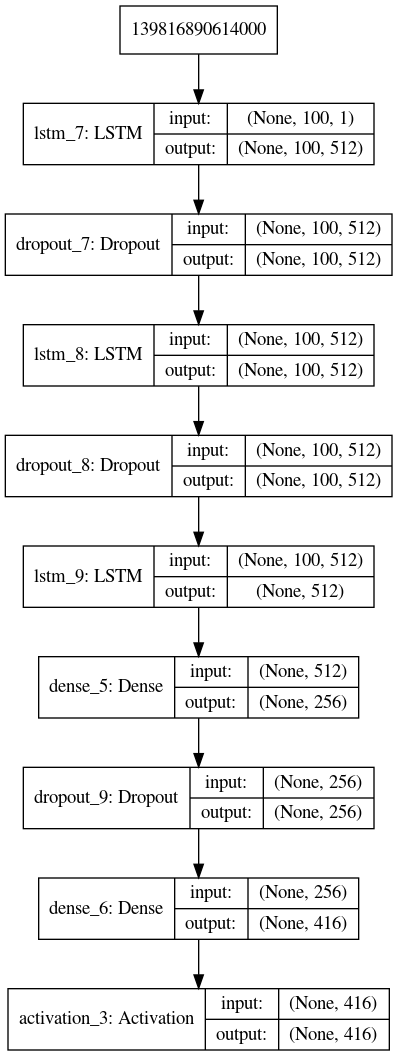

In [0]:
Image(retina=True, filename='figs/midi_LSTM.png')

Ya que tienes el modelo entrenado y guardado, puedes generar una secuencia y guardarlo en archivo MIDI con el siguiente código

In [0]:
def prepare_sequences_test(notes, pitchnames, n_vocab):
    """ Prepara las secuencias para usar en el modelo entrenado """
    
    # aqui, se realiza un mapeo (con diccionario) entre las notas y valores enteros y al reves
    note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

    sequence_length = 100
    network_input = []
    output = []
    for i in range(0, len(notes) - sequence_length, 1):
        sequence_in = notes[i:i + sequence_length]
        sequence_out = notes[i + sequence_length]
        network_input.append([note_to_int[char] for char in sequence_in])
        output.append(note_to_int[sequence_out])

    n_patterns = len(network_input)

    # como antes, redimensionamos las entradas para poder usarse con LSTM
    normalized_input = numpy.reshape(network_input, (n_patterns, sequence_length, 1))
    # normalizamos la entrada
    normalized_input = normalized_input / float(n_vocab)

    return (network_input, normalized_input)

def generate_notes_test(model, network_input, network_input2, pitchnames, n_vocab):
    """ Genera notas musicales a partir de una red neuronal basado en una secuencia inicial de notas """
    
    # selecciona una secuencia aleatoria del input a partir de la cual se realizaran predicciones
    start = numpy.random.randint(0, len(network_input)-1)

    int_to_note = dict((number, note) for number, note in enumerate(pitchnames))

    pattern = network_input[start]
    prediction_output = []

    # genera 500 notas (puedes cambiarlo)
    for note_index in range(500):
        prediction_input = numpy.reshape(pattern, (1, len(pattern), 1))
        prediction_input = prediction_input / float(n_vocab)

        prediction_input2 = numpy.reshape(pattern, (1, len(pattern), 1))
        prediction_input2 = prediction_input / float(n_vocab)

        prediction = model.predict([prediction_input,prediction_input2], verbose=0)

        index = numpy.argmax(prediction)
        result = int_to_note[index]
        prediction_output.append(result)

        pattern.append(index)
        pattern = pattern[1:len(pattern)]

    return prediction_output

    
def create_midi(prediction_output, midfile):
    """ genera un archivo MIDI a partir de las notas generadas (o predichas) """
    offset = 0
    output_notes = []

    # crea los objetos fundamentales Note y Chrod basado en los valores genrados por el modelo entrenado
    for pattern in prediction_output:
        # si las notas forman un acorde...
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                new_note = note.Note(int(current_note))
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        # si son notas...
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

        # incremental el offset en cada iteracion. El offset es la posicion dentro del stream de musica
        offset += 0.5

    midi_stream = stream.Stream(output_notes)

    midi_stream.write('midi', fp = midfile)
    
    return midi_stream


Suponiendo que ya creaste un modelo (my_model), lo entrenaste y LO GUARDASTE, el siguiente código genera la música a partir de ese modelo

In [0]:
%cd /content/drive/My Drive/Colab Notebooks/Tarea 3-20191016/midi_train/
# carga las notas usadas cuando se entreno el modelo
with open('programs/notebooks/data_mid/notes', 'rb') as filepath:
    notes = pickle.load(filepath)

# Obtiene el nombre de todas las notas (pitches)
pitchnames = sorted(set(item for item in notes))
n_vocab = len(set(notes))


with open('programs/notebooks/data_mid/notes2', 'rb') as filepath:
    notes2 = pickle.load(filepath)

# Obtiene el nombre de todas las notas (pitches)
pitchnames2 = sorted(set(item for item in notes2))
n_vocab2 = len(set(notes2))

/content/drive/My Drive/Colab Notebooks/Tarea 3-20191016/midi_train


In [0]:
""" Obtiene las secuencias Genera las notas y el archivo MIDI (piano) """
network_input, normalized_input = prepare_sequences_test(notes, pitchnames, n_vocab)
network_input2, normalized_input2 = prepare_sequences_test(notes2, pitchnames2, n_vocab2)


In [0]:
len(network_input)

154329

In [0]:
len(network_input2[:index])

154329

In [0]:
index

154329

In [0]:
lstm1 = LSTM(256, return_sequences=True)
lstm2 = LSTM(256, return_sequences=True)
lstm3 = LSTM(256)


left_input = Input(shape=(normalized_input.shape[1], normalized_input.shape[2]))
x = lstm1(left_input)
x = Dropout(0.3)(x)
x = lstm2(x)
x = Dropout(0.3)(x)
left_output = lstm3(x)



right_input = Input(shape=(normalized_input.shape[1], normalized_input.shape[2]))
x = lstm1(right_input)
x = Dropout(0.3)(x)
x = lstm2(x)
x = Dropout(0.3)(x)
right_output = lstm3(x)


merged = tensorflow.keras.layers.concatenate([left_output, right_output], axis=-1)
dens1 = Dense(256)(merged)
drop1 = Dropout(0.3)(dens1)
output =Dense(n_vocab, activation='softmax')(drop1)

model = Model([left_input, right_input], output)

model.compile(loss='categorical_crossentropy', optimizer='adam')


In [0]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop')

In [0]:
model.load_weights('siames.hdf5')

SUGERENCIAS: 
- Guarda tu modelo en formato hdf5. Puedes guardar todo o parte, por ejemplo, solo los pesos, pero tendrás que re-definir la arquitectura en la fase de test.
- Usa callbacks y model check points para guardar tu modelo en cada época. Puede tardar mucho tiempo para entrenarse...

In [0]:
# genera las anotas
prediction_output = generate_notes_test(model, network_input,  network_input2[:index], pitchnames, n_vocab)


In [0]:
# crea el MIDI
notitas = create_midi(prediction_output, 'modelito2.mid')

In [0]:
notitas.show()


SubConverterException: ignored

In [0]:
notitas.show('midi')

## b) La generación de música que hicimos es muy básica y tiene varias limitaciones (¡pero aún así es sorprendente!). Una de ellas es que las notas generadas tienen solo una duración. Otra es que solo usan un instrumento. ¿Qué ideas se te ocurren para extender el método en ambos casos, que puedan implementarse en términos de redes recurrentes o Deep Learning en general?

## Quizá la lectura de Briot et al. (2019, 2017) y Huang & Wu (2016) puedan ayudar.